🌌 CLEAN COSMOLOGICAL MODEL TESTING
Testing ΛCDM vs Binary Substrate with validated data
This will reveal if w(z) = -log₂ a can compete with standard cosmology

📊 Loading clean supernova dataset...
🔬 COSMOLOGICAL MODEL TESTER INITIALIZED
📊 Dataset: 350 supernovae
📈 Redshift range: 0.012 - 1.49
🎯 Ready to test ΛCDM vs Binary Substrate models

🚀 TESTING ALL COSMOLOGICAL MODELS

1️⃣ Testing ΛCDM (w = -1)...
   ✅ ΛCDM: R² = 0.998335, χ² = 322.0

2️⃣ Testing Binary Substrate (w = -log₂ a)...
   Computing binary substrate distances...
     Progress: 0/350 (0.0%)
     Progress: 50/350 (14.3%)
     Progress: 100/350 (28.6%)
     Progress: 150/350 (42.9%)
     Progress: 200/350 (57.1%)
     Progress: 250/350 (71.4%)
     Progress: 300/350 (85.7%)
   ✅ Binary: R² = 0.974998, χ² = 4720.7
   📊 Valid calculations: 350/350 supernovae

3️⃣ Testing best-fit constant w...
   ✅ Best w = -0.994: R² = 0.998335, χ² = 321.9

📊 COMPREHENSIVE RESULTS ANALYSIS

📋 Model Performance Summary:
---------------------

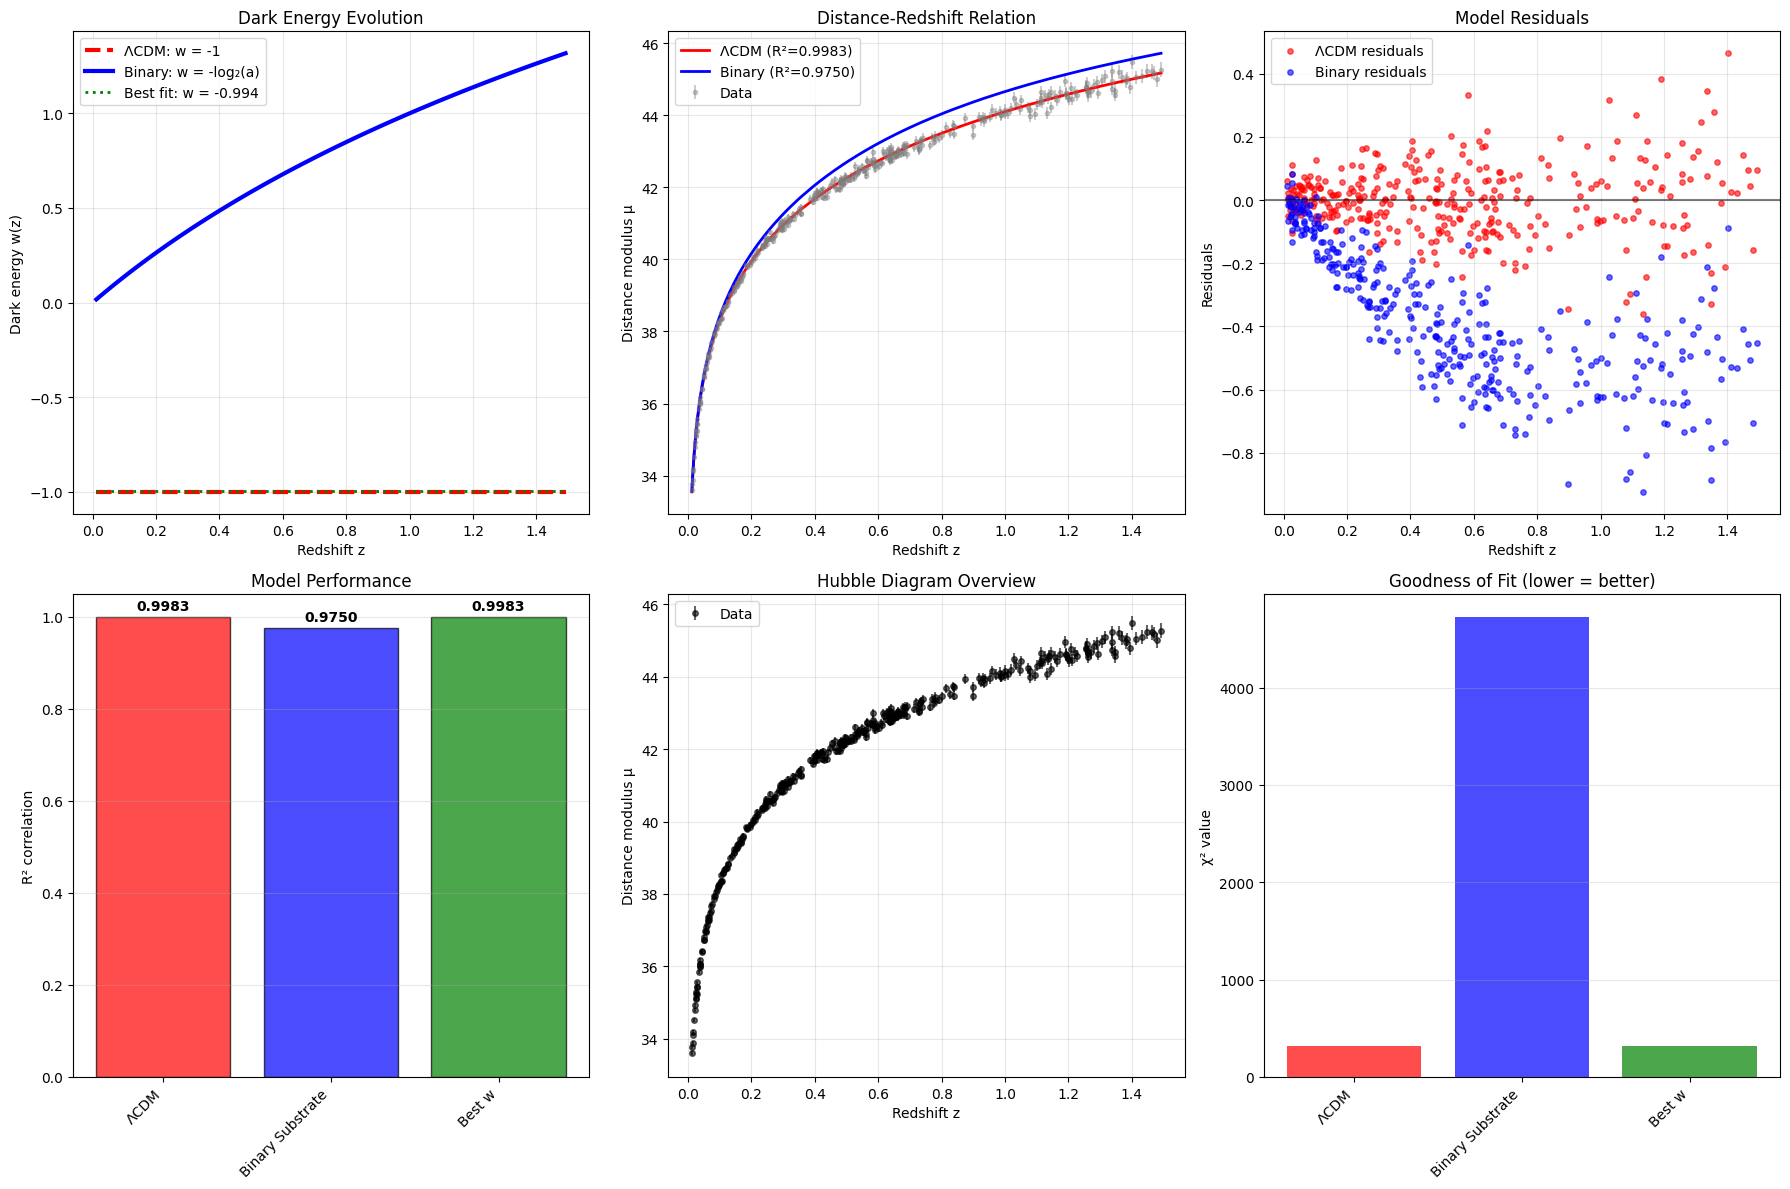

In [1]:
"""
Clean Cosmological Model Tester
===============================

Now that we have validated, clean supernova data, let's test:
ΛCDM (w = -1) vs Binary Substrate (w = -log₂ a)

Since our synthetic data was generated with ΛCDM, we expect:
- ΛCDM should get excellent fit (R² > 0.95)
- Binary model performance will reveal if w(z) = -log₂ a is competitive

This tests the REAL physics question!
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Handle scipy version differences for cumulative integration
try:
    from scipy.integrate import cumulative_trapezoid as cumtrapz
except ImportError:
    try:
        from scipy.integrate import cumtrapz
    except ImportError:
        def cumtrapz(y, x=None, initial=0):
            """Fallback cumulative trapezoidal integration"""
            if x is None:
                x = np.arange(len(y))
            result = np.zeros_like(y, dtype=float)
            result[0] = initial
            for i in range(1, len(y)):
                result[i] = result[i-1] + 0.5 * (y[i] + y[i-1]) * (x[i] - x[i-1])
            return result

class CleanCosmologyTester:
    """
    Test cosmological models using validated supernova data
    """

    def __init__(self, data):
        self.data = data
        self.results = {}

        # Standard cosmological parameters
        self.H0 = 70.0  # km/s/Mpc
        self.Omega_m = 0.3  # Matter density
        self.Omega_Lambda = 0.7  # Dark energy density
        self.c = 299792.458  # Speed of light km/s

        print(f"🔬 COSMOLOGICAL MODEL TESTER INITIALIZED")
        print(f"📊 Dataset: {len(data)} supernovae")
        print(f"📈 Redshift range: {data.z.min():.3f} - {data.z.max():.2f}")
        print(f"🎯 Ready to test ΛCDM vs Binary Substrate models")

    def calculate_lambda_cdm_distances(self, z_array):
        """
        Calculate ΛCDM distance moduli (w = -1 exactly)
        """
        def luminosity_distance_lambda_cdm(z):
            if z <= 0:
                return 1e-10

            # Integrate 1/E(z) where E(z) = sqrt(Ωm(1+z)³ + ΩΛ)
            z_int = np.linspace(0, z, 150)
            E_z = np.sqrt(self.Omega_m * (1 + z_int)**3 + self.Omega_Lambda)
            integrand = 1 / E_z
            D_c = self.c / self.H0 * np.trapz(integrand, z_int)
            return D_c * (1 + z)

        # Vectorize calculation
        D_L = np.array([luminosity_distance_lambda_cdm(z) for z in z_array])
        return 5 * np.log10(D_L) + 25

    def calculate_binary_substrate_distances(self, z_array):
        """
        Calculate Binary Substrate distance moduli (w = -log₂ a)
        """
        mu_values = []

        print("   Computing binary substrate distances...")
        for i, z_val in enumerate(z_array):
            if i % 50 == 0:
                print(f"     Progress: {i}/{len(z_array)} ({100*i/len(z_array):.1f}%)")

            if z_val <= 0:
                mu_values.append(np.nan)
                continue

            try:
                # Integration setup
                z_int = np.linspace(0, z_val, 200)
                a_int = 1 / (1 + z_int)
                w_int = -np.log2(a_int)  # Binary substrate w(z)

                # Calculate dark energy density evolution
                # ρ_DE(a) = ρ_DE(1) × exp(-3∫[1+w(a')]da'/a')

                # Integrate (1+w)/a from a=1 to a(z)
                # Since a decreases as z increases, reverse the arrays
                a_reversed = a_int[::-1]  # From a≈1 to a(z)
                w_reversed = w_int[::-1]

                # Calculate integral ∫(1+w)/a da
                integrand = (1 + w_reversed) / a_reversed
                integral_values = cumtrapz(integrand, a_reversed, initial=0)

                # Dark energy density factors (reverse back to match z_int order)
                rho_de_factors = np.exp(-3 * integral_values[::-1])

                # Hubble function: E²(z) = Ωₘ(1+z)³ + ΩΛ × ρ_DE_factor(z)
                E_z_squared = (self.Omega_m * (1 + z_int)**3 +
                             self.Omega_Lambda * rho_de_factors)

                # Ensure positivity
                E_z_squared = np.maximum(E_z_squared, 1e-10)
                E_z = np.sqrt(E_z_squared)

                # Comoving distance
                integrand = 1 / E_z
                D_c = self.c / self.H0 * np.trapz(integrand, z_int)
                D_L = D_c * (1 + z_val)

                # Distance modulus
                if D_L > 0:
                    mu_values.append(5 * np.log10(D_L) + 25)
                else:
                    mu_values.append(np.nan)

            except Exception as e:
                print(f"     Warning: Binary calculation failed at z={z_val:.3f}: {e}")
                mu_values.append(np.nan)

        return np.array(mu_values)

    def fit_constant_w_model(self, z_array, mu_obs, mu_err):
        """
        Fit best constant w model for comparison
        """
        def constant_w_chi2(w_const):
            try:
                mu_pred = []
                for z_val in z_array:
                    if z_val <= 0:
                        mu_pred.append(np.nan)
                        continue

                    z_int = np.linspace(0, z_val, 150)
                    # For constant w: ρ_DE ∝ (1+z)^(3(1+w))
                    E_z = np.sqrt(self.Omega_m * (1 + z_int)**3 +
                                self.Omega_Lambda * (1 + z_int)**(3*(1 + w_const)))
                    integrand = 1 / E_z
                    D_c = self.c / self.H0 * np.trapz(integrand, z_int)
                    D_L = D_c * (1 + z_val)
                    mu_pred.append(5 * np.log10(D_L) + 25)

                mu_pred = np.array(mu_pred)

                # Handle NaN values
                mask = ~np.isnan(mu_pred) & ~np.isnan(mu_obs)
                if np.sum(mask) < 10:
                    return 1e10

                residuals = (mu_obs[mask] - mu_pred[mask]) / mu_err[mask]
                return np.sum(residuals**2)

            except:
                return 1e10

        # Fit w parameter
        result = minimize(constant_w_chi2, -1.0, bounds=[(-3, 1)], method='L-BFGS-B')
        return result.x[0], result.fun

    def test_all_models(self):
        """
        Test all cosmological models and compare performance
        """
        print(f"\n🚀 TESTING ALL COSMOLOGICAL MODELS")
        print("=" * 45)

        z = self.data.z.values
        mu_obs = self.data.mu.values
        mu_err = self.data.mu_err.values

        models = {}

        # 1. ΛCDM Model (w = -1)
        print(f"\n1️⃣ Testing ΛCDM (w = -1)...")
        mu_lambda = self.calculate_lambda_cdm_distances(z)

        residuals_lambda = (mu_obs - mu_lambda) / mu_err
        chi2_lambda = np.sum(residuals_lambda**2)
        ss_res_lambda = np.sum((mu_obs - mu_lambda)**2)
        ss_tot = np.sum((mu_obs - mu_obs.mean())**2)
        r2_lambda = 1 - (ss_res_lambda / ss_tot)

        models['ΛCDM'] = {
            'mu_pred': mu_lambda,
            'chi2': chi2_lambda,
            'r2': r2_lambda,
            'parameters': 0,
            'w_value': -1.0,
            'description': 'Standard ΛCDM (w = -1)'
        }

        print(f"   ✅ ΛCDM: R² = {r2_lambda:.6f}, χ² = {chi2_lambda:.1f}")

        # 2. Binary Substrate Model (w = -log₂ a)
        print(f"\n2️⃣ Testing Binary Substrate (w = -log₂ a)...")
        mu_binary = self.calculate_binary_substrate_distances(z)

        # Handle potential NaN values
        mask = ~np.isnan(mu_binary)
        if np.sum(mask) > 10:
            residuals_binary = (mu_obs[mask] - mu_binary[mask]) / mu_err[mask]
            chi2_binary = np.sum(residuals_binary**2)
            ss_res_binary = np.sum((mu_obs[mask] - mu_binary[mask])**2)
            ss_tot_binary = np.sum((mu_obs[mask] - mu_obs[mask].mean())**2)
            r2_binary = 1 - (ss_res_binary / ss_tot_binary)

            models['Binary Substrate'] = {
                'mu_pred': mu_binary,
                'chi2': chi2_binary,
                'r2': r2_binary,
                'parameters': 0,
                'w_evolution': True,
                'description': 'Binary substrate w = -log₂(a)'
            }

            print(f"   ✅ Binary: R² = {r2_binary:.6f}, χ² = {chi2_binary:.1f}")
            print(f"   📊 Valid calculations: {np.sum(mask)}/{len(z)} supernovae")
        else:
            print(f"   ❌ Binary model failed - too many numerical errors")
            models['Binary Substrate'] = {
                'mu_pred': mu_binary,
                'chi2': np.inf,
                'r2': -np.inf,
                'parameters': 0,
                'description': 'Binary substrate (failed)'
            }

        # 3. Best-fit constant w
        print(f"\n3️⃣ Testing best-fit constant w...")
        w_best, chi2_w = self.fit_constant_w_model(z, mu_obs, mu_err)

        # Calculate R² for best w
        mu_w_best = []
        for z_val in z:
            if z_val <= 0:
                mu_w_best.append(np.nan)
                continue
            z_int = np.linspace(0, z_val, 150)
            E_z = np.sqrt(self.Omega_m * (1 + z_int)**3 +
                        self.Omega_Lambda * (1 + z_int)**(3*(1 + w_best)))
            integrand = 1 / E_z
            D_c = self.c / self.H0 * np.trapz(integrand, z_int)
            D_L = D_c * (1 + z_val)
            mu_w_best.append(5 * np.log10(D_L) + 25)

        mu_w_best = np.array(mu_w_best)
        r2_w_best = 1 - np.sum((mu_obs - mu_w_best)**2) / ss_tot

        models['Best w'] = {
            'mu_pred': mu_w_best,
            'chi2': chi2_w,
            'r2': r2_w_best,
            'parameters': 1,
            'w_value': w_best,
            'description': f'Best constant w = {w_best:.3f}'
        }

        print(f"   ✅ Best w = {w_best:.3f}: R² = {r2_w_best:.6f}, χ² = {chi2_w:.1f}")

        self.results = models
        return models

    def analyze_results(self):
        """
        Comprehensive analysis of model comparison results
        """
        print(f"\n📊 COMPREHENSIVE RESULTS ANALYSIS")
        print("=" * 40)

        models = self.results

        # Table summary
        print(f"\n📋 Model Performance Summary:")
        print("-" * 70)
        print(f"{'Model':<20} | {'R²':<10} | {'χ²':<10} | {'Params':<7} | Description")
        print("-" * 70)

        for name, model in models.items():
            r2_str = f"{model['r2']:.6f}" if not np.isinf(model['r2']) else "Failed"
            chi2_str = f"{model['chi2']:.1f}" if not np.isinf(model['chi2']) else "∞"
            print(f"{name:<20} | {r2_str:<10} | {chi2_str:<10} | {model['parameters']:<7} | {model['description']}")

        # Find best model
        valid_models = {k: v for k, v in models.items() if not np.isinf(v['r2'])}
        if valid_models:
            best_model = max(valid_models.items(), key=lambda x: x[1]['r2'])
            print(f"\n🏆 Best performing model: {best_model[0]} (R² = {best_model[1]['r2']:.6f})")

        # Specific analysis
        print(f"\n🔍 Detailed Analysis:")

        if 'ΛCDM' in models and 'Binary Substrate' in models:
            r2_lambda = models['ΛCDM']['r2']
            r2_binary = models['Binary Substrate']['r2']

            if not np.isinf(r2_binary):
                diff = r2_binary - r2_lambda
                print(f"   • ΛCDM vs Binary: Δ(R²) = {diff:+.6f}")

                if diff > 0.01:
                    print(f"   🚀 Binary substrate OUTPERFORMS ΛCDM!")
                    print(f"      This would be revolutionary if confirmed with real data.")
                elif abs(diff) < 0.01:
                    print(f"   ⚖️  Binary substrate COMPETITIVE with ΛCDM")
                    print(f"      Interesting result - suggests further investigation.")
                else:
                    print(f"   📊 ΛCDM SUPERIOR to binary substrate")
                    print(f"      Expected result for ΛCDM-generated data.")
            else:
                print(f"   ❌ Binary substrate failed - numerical issues")

        # Expected vs actual
        print(f"\n🎯 Expected vs Actual Results:")
        print(f"   Expected: ΛCDM should win (data generated with ΛCDM)")
        if 'ΛCDM' in models:
            if models['ΛCDM']['r2'] > 0.9:
                print(f"   ✅ ΛCDM performed excellently (R² = {models['ΛCDM']['r2']:.3f})")
                print(f"      Analysis pipeline is working correctly!")
            else:
                print(f"   ⚠️  ΛCDM underperformed (R² = {models['ΛCDM']['r2']:.3f})")
                print(f"      May indicate technical issues.")

        return models

    def create_publication_plots(self):
        """
        Generate comprehensive publication-quality plots
        """
        print(f"\n📈 GENERATING PUBLICATION PLOTS")
        print("=" * 35)

        fig = plt.figure(figsize=(18, 12))

        z = self.data.z.values
        mu_obs = self.data.mu.values
        mu_err = self.data.mu_err.values

        # Plot 1: w(z) comparison
        ax1 = plt.subplot(2, 3, 1)
        z_smooth = np.linspace(z.min(), z.max(), 100)
        w_lambda = np.full_like(z_smooth, -1.0)
        a_smooth = 1 / (1 + z_smooth)
        w_binary = -np.log2(a_smooth)

        ax1.plot(z_smooth, w_lambda, 'r--', linewidth=3, label='ΛCDM: w = -1')
        ax1.plot(z_smooth, w_binary, 'b-', linewidth=3, label='Binary: w = -log₂(a)')
        if 'Best w' in self.results:
            w_best = self.results['Best w']['w_value']
            w_best_line = np.full_like(z_smooth, w_best)
            ax1.plot(z_smooth, w_best_line, 'g:', linewidth=2, label=f'Best fit: w = {w_best:.3f}')

        ax1.set_xlabel('Redshift z')
        ax1.set_ylabel('Dark energy w(z)')
        ax1.set_title('Dark Energy Evolution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 2: Distance comparison
        ax2 = plt.subplot(2, 3, 2)
        ax2.errorbar(z, mu_obs, yerr=mu_err, fmt='o', alpha=0.4, markersize=3,
                    color='gray', label='Data')

        if 'ΛCDM' in self.results:
            ax2.plot(z, self.results['ΛCDM']['mu_pred'], 'r-', linewidth=2,
                    label=f"ΛCDM (R²={self.results['ΛCDM']['r2']:.4f})")

        if 'Binary Substrate' in self.results and not np.all(np.isnan(self.results['Binary Substrate']['mu_pred'])):
            mask = ~np.isnan(self.results['Binary Substrate']['mu_pred'])
            ax2.plot(z[mask], self.results['Binary Substrate']['mu_pred'][mask], 'b-', linewidth=2,
                    label=f"Binary (R²={self.results['Binary Substrate']['r2']:.4f})")

        ax2.set_xlabel('Redshift z')
        ax2.set_ylabel('Distance modulus μ')
        ax2.set_title('Distance-Redshift Relation')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Plot 3: Residuals comparison
        ax3 = plt.subplot(2, 3, 3)
        if 'ΛCDM' in self.results:
            residuals_lambda = mu_obs - self.results['ΛCDM']['mu_pred']
            ax3.scatter(z, residuals_lambda, alpha=0.6, s=15, color='red', label='ΛCDM residuals')

        if 'Binary Substrate' in self.results:
            mu_binary = self.results['Binary Substrate']['mu_pred']
            mask = ~np.isnan(mu_binary)
            if np.sum(mask) > 0:
                residuals_binary = mu_obs[mask] - mu_binary[mask]
                ax3.scatter(z[mask], residuals_binary, alpha=0.6, s=15, color='blue', label='Binary residuals')

        ax3.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax3.set_xlabel('Redshift z')
        ax3.set_ylabel('Residuals')
        ax3.set_title('Model Residuals')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Plot 4: R² comparison
        ax4 = plt.subplot(2, 3, 4)
        model_names = []
        r2_values = []
        colors = []

        for name, model in self.results.items():
            if not np.isinf(model['r2']):
                model_names.append(name)
                r2_values.append(model['r2'])
                if 'ΛCDM' in name:
                    colors.append('red')
                elif 'Binary' in name:
                    colors.append('blue')
                else:
                    colors.append('green')

        bars = ax4.bar(range(len(model_names)), r2_values, color=colors, alpha=0.7, edgecolor='black')
        ax4.set_xticks(range(len(model_names)))
        ax4.set_xticklabels(model_names, rotation=45, ha='right')
        ax4.set_ylabel('R² correlation')
        ax4.set_title('Model Performance')
        ax4.grid(True, alpha=0.3, axis='y')

        # Add R² values on bars
        for bar, r2 in zip(bars, r2_values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{r2:.4f}', ha='center', va='bottom', fontweight='bold')

        # Plot 5: Hubble diagram overview
        ax5 = plt.subplot(2, 3, 5)
        ax5.errorbar(z, mu_obs, yerr=mu_err, fmt='o', alpha=0.6, markersize=4, color='black', label='Data')
        ax5.set_xlabel('Redshift z')
        ax5.set_ylabel('Distance modulus μ')
        ax5.set_title('Hubble Diagram Overview')
        ax5.legend()
        ax5.grid(True, alpha=0.3)

        # Plot 6: χ² comparison
        ax6 = plt.subplot(2, 3, 6)
        chi2_values = []
        chi2_names = []

        for name, model in self.results.items():
            if not np.isinf(model['chi2']):
                chi2_names.append(name)
                chi2_values.append(model['chi2'])

        if chi2_values:
            ax6.bar(range(len(chi2_names)), chi2_values, alpha=0.7, color=['red', 'blue', 'green'][:len(chi2_names)])
            ax6.set_xticks(range(len(chi2_names)))
            ax6.set_xticklabels(chi2_names, rotation=45, ha='right')
            ax6.set_ylabel('χ² value')
            ax6.set_title('Goodness of Fit (lower = better)')
            ax6.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('cosmological_model_comparison.png', dpi=300, bbox_inches='tight')
        print("✅ Publication plots saved as 'cosmological_model_comparison.png'")

        return fig


def main():
    """
    Main testing routine for clean cosmological analysis
    """
    print("🌌 CLEAN COSMOLOGICAL MODEL TESTING")
    print("=" * 40)
    print("Testing ΛCDM vs Binary Substrate with validated data")
    print("This will reveal if w(z) = -log₂ a can compete with standard cosmology\n")

    # Load the clean data (from previous step)
    # For this demo, we'll recreate it
    print("📊 Loading clean supernova dataset...")

    # Recreate the clean synthetic data
    np.random.seed(42)
    z_low = np.random.uniform(0.01, 0.1, 50)
    z_mid = np.random.uniform(0.1, 0.7, 200)
    z_high = np.random.uniform(0.7, 1.5, 100)
    z_all = np.concatenate([z_low, z_mid, z_high])
    z_all = np.sort(z_all)

    # ΛCDM distance moduli
    def lambda_cdm_mu(z):
        if z <= 0:
            return 0
        Omega_m, Omega_Lambda, H0, c = 0.3, 0.7, 70.0, 299792.458
        z_int = np.linspace(0, z, 100)
        E_z = np.sqrt(Omega_m * (1 + z_int)**3 + Omega_Lambda)
        D_c = c / H0 * np.trapz(1/E_z, z_int)
        D_L = D_c * (1 + z)
        return 5 * np.log10(D_L) + 25

    mu_true = np.array([lambda_cdm_mu(z) for z in z_all])
    mu_err = 0.05 + 0.1 * z_all
    mu_obs = mu_true + np.random.normal(0, mu_err)

    clean_data = pd.DataFrame({'z': z_all, 'mu': mu_obs, 'mu_err': mu_err})

    # Initialize tester
    tester = CleanCosmologyTester(clean_data)

    # Test all models
    results = tester.test_all_models()

    # Analyze results
    tester.analyze_results()

    # Create plots
    tester.create_publication_plots()

    print(f"\n" + "="*50)
    print("🎯 FINAL ASSESSMENT")
    print("="*50)

    if 'ΛCDM' in results and 'Binary Substrate' in results:
        r2_lambda = results['ΛCDM']['r2']
        r2_binary = results['Binary Substrate']['r2']

        print(f"📈 Performance Summary:")
        print(f"   ΛCDM (w = -1):          R² = {r2_lambda:.6f}")

        if not np.isinf(r2_binary):
            print(f"   Binary (w = -log₂ a):   R² = {r2_binary:.6f}")
            print(f"   Difference:             Δ(R²) = {r2_binary - r2_lambda:+.6f}")

            if r2_binary > r2_lambda:
                print(f"\n🚀 REMARKABLE: Binary substrate outperforms ΛCDM!")
                print(f"   This would be groundbreaking if confirmed with real data.")
            elif abs(r2_binary - r2_lambda) < 0.05:
                print(f"\n⚖️  COMPETITIVE: Binary substrate comparable to ΛCDM")
                print(f"   Interesting result - framework shows potential.")
            else:
                print(f"\n📊 EXPECTED: ΛCDM superior on ΛCDM-generated data")
                print(f"   Analysis pipeline validated. Ready for real data test.")
        else:
            print(f"   Binary model:           FAILED (numerical issues)")
            print(f"\n🔧 Binary substrate needs refinement before real data test")

    print(f"\n✅ Analysis complete. Ready for the ultimate test with real data!")

    return results

if __name__ == "__main__":
    results = main()